### 네이버 스포츠뉴스 --> 워드클라우드

In [1]:
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By

- 네이버 스포츠 뉴스 크롤링

In [17]:
sports = ['kbaseball','wbaseball','kfootball','wfootball','basketball','volleyball','golf', 'general']
base_url = 'https://sports.news.naver.com/'
suffix_url = '/news/index?isphoto=N&page='

In [18]:
driver = webdriver.Chrome()
url = f'{base_url}kbaseball{suffix_url}1'
driver.get(url)

In [6]:
# 기사 목록
soup = BeautifulSoup(driver.page_source, 'html.parser')
lis = soup.select('.news_list > ul > li')
len(lis)

20

In [7]:
# 기사 제목
li = lis[0]
title = li.select_one('.title').get_text().strip()
title

'AG 출전 의지 강했던 132억 좌완 에이스, 결국 출전 불발…김영규 대체 발탁, 이정후→김성윤 교체 [MK항저우]'

- 종목별로 몇 페이지가 있는지 확인하기

In [9]:
# 10 페이지가 넘는 종목 선택
url = f'{base_url}wfootball{suffix_url}1'
driver.get(url)

In [20]:
sports_dict = {}
for sport in sports:
    url = f'{base_url}{sport}{suffix_url}1'
    driver.get(url)
    time.sleep(2)

    next_clicked = 0
    while True:
        try:
            driver.find_element(By.CSS_SELECTOR, '.paginate > .next').click()
            next_clicked += 1
            time.sleep(2)
        except:     # 모든 종목의 마지막 페이지가 있는 화면
            pages = driver.find_elements(By.CSS_SELECTOR, '.paginate > a')       # a tage의 갯수로
            if next_clicked == 0:
                num_pages = len(pages) + 1          # atag가 필요한 페이지 갯수보다 1개 모자람.
            else:
                num_pages = next_clicked * 10 + len(pages)  # 이전까지 합쳐서 페이지 갯수만큰 있음.
            sports_dict[sport] = num_pages
            break

sports_dict

{'kbaseball': 7,
 'wbaseball': 5,
 'kfootball': 7,
 'wfootball': 14,
 'basketball': 6,
 'volleyball': 5,
 'golf': 3,
 'general': 11}

- 모든 종목, 모든 페이지에 대해서 타이틀 가져오기

In [22]:
data = []
for sport, num_pages in sports_dict.items():
    for page in range(num_pages):
        url = f'{base_url}{sport}{suffix_url}{page+1}'
        driver.get(url)
        time.sleep(2)

        soup = BeautifulSoup(driver.page_source, 'html.parser')
        lis = soup.select('.news_list > ul > li')
        for li in lis:
            title = li.select_one('.title').get_text().strip()
            data.append(title)
            

In [23]:
with open('data/sports_news.txt', 'w', encoding='UTF-8') as file:
    for item in data:
        file.write(item + '\n')

In [47]:
import re, nltk
from konlpy.tag import Okt
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [25]:
with open('data/sports_news.txt') as file:
    text = file.read()

In [26]:
okt = Okt()
tokens = okt.nouns(text)     # 문장에서 명사 추출
tokens[:10]

['구창모', '제외', '류중일', '감독', '선발', '등판', '무리', '판단', '항저우', '류중일']

In [41]:
news = nltk.Text(tokens, name='스포츠 기사')
wc = WordCloud(
    background_color='white', random_state=2023,
    font_path='C:/Windows/Fonts/malgun.ttf', relative_scaling=0.4
).generate_from_frequencies(dict(news.vocab().most_common(300)))

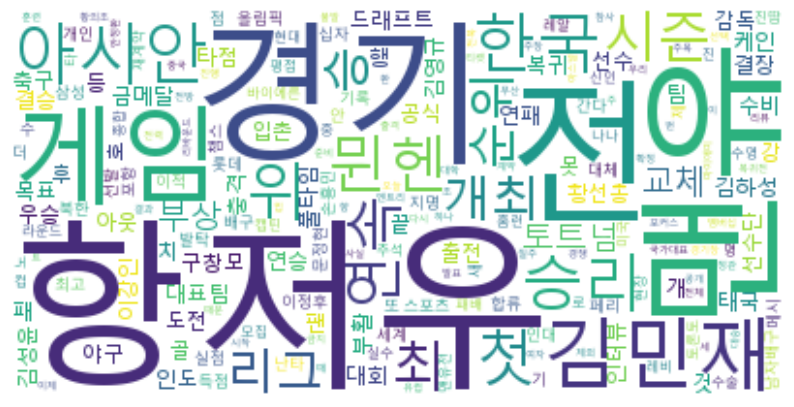

In [43]:
plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off');

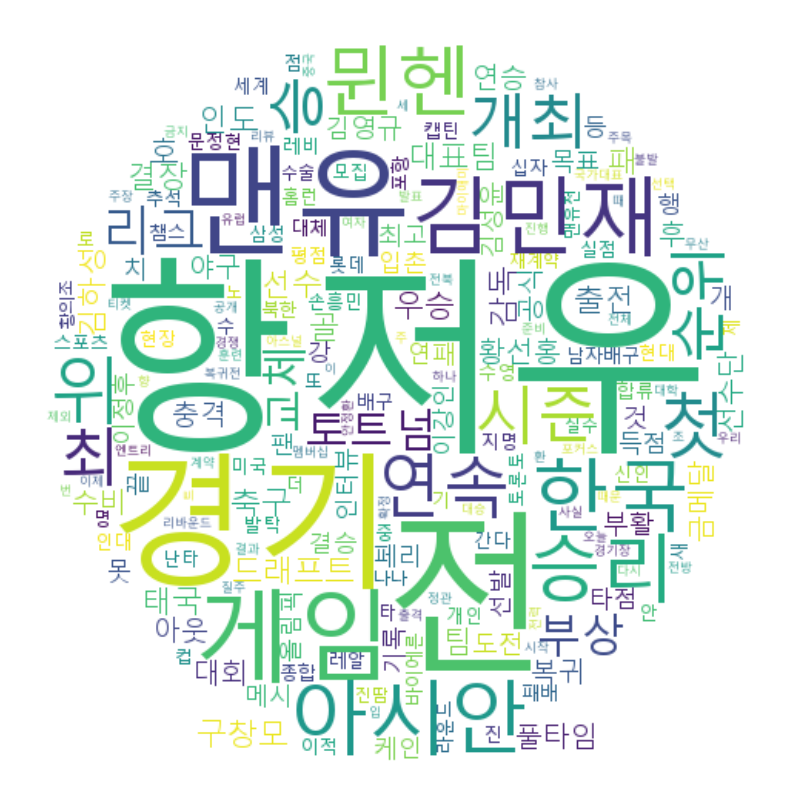

In [46]:
mask = np.array(Image.open('data/ball.jpg'))
wc = WordCloud(
    background_color='white', random_state=2023, mask=mask,
    font_path='C:/Windows/Fonts/malgun.ttf', relative_scaling=0.4
).generate_from_frequencies(dict(news.vocab().most_common(300)))

plt.figure(figsize=(12, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off');

In [27]:
new_token = []
for token in tokens:
    item = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '', token)
    if item:
        new_token.append(item)
len(new_token)

9876

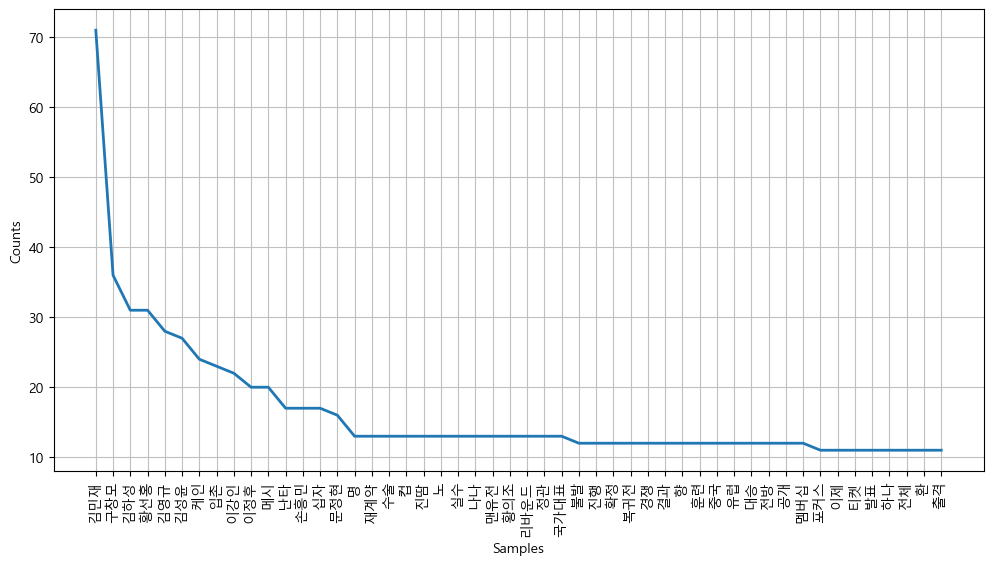

In [37]:
sport_item = nltk.Text(new_token, name='스포츠 기사')
plt.figure(figsize=(12,6))
sport_item.plot(50);      # Text.plot / Series

In [36]:
stoptext = """
        항저우 전 경기 맨유 게임 아시안 한국 뮌헨 승리 위 쳇 연속 시즌 최 개회 승 순위 리그 토트넘 부상 교체
        드레프트 감독 팀 대표팀 태국 골 인도 우승 출전 패 선수 축구 호 결장 충격 금메달 풀타임 후 공식 선수단
        수비 복귀 아웃 연승 대회 쳇 개최 드래프트 야구 도전 개 부활 등 팬 치 끝 강 것 임존 결승 못 연패 타점
        행 인터뷰 목표 올림픽 페리 선발 최고 기록 득점 남자배구 배구 더 수 실점 발탁 안 간다 포항 세계 챔스
        지명 대체 첫 점 스포츠 제 심자 삼성 롯데 또 새 인대 개인 북한 합류 이적 기 바이에른 레비 모집 라운드
        로 신인 현장 캡틴 토론토 중 진 현대 미국 레알 평점 패배 수영 홈런 종합 추석 타 첫
"""

stop_words = stoptext.split()
new_token = [token for token in new_token if token not in stop_words]
new_token[:10]

['구창모', '제외', '류중일', '등판', '무리', '판단', '류중일', '구창모', '완전', '김영규']

In [38]:
sport_item.vocab().most_common(5)

[('김민재', 71), ('구창모', 36), ('김하성', 31), ('황선홍', 31), ('김영규', 28)]

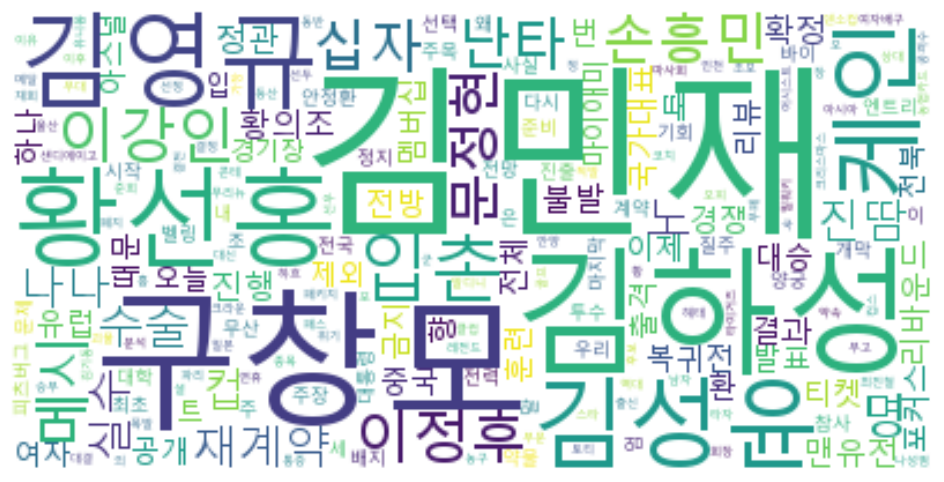

In [39]:
wc = WordCloud(
    background_color='white', random_state=2023,
    # font_path='C:/Users/human/AppData/Local/Microsoft/Windows/Fonts/NanumMyeongjo.ttf'
    font_path='C:/Windows/Fonts/malgun.ttf',
    relative_scaling=0.4
).generate_from_frequencies(dict(sport_item.vocab().most_common(300)))

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off');